In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score


In [ ]:
loaded_data = np.load("embeddings/hyb_emb.npz")
embeddings = {key: loaded_data[key] for key in loaded_data}

(1024,)


In [3]:
df = pd.read_csv('labels.csv')

In [4]:
train_labels=pd.read_csv('train_pairs.csv')

ast_pairs_train = []
labels_train = []

for _, row in train_labels.iterrows():  
    temp = row['sub'].split('_')

    if temp[0] in embeddings.keys() and temp[1] in embeddings.keys():
        ast1 = embeddings[temp[0]]
        ast2 = embeddings[temp[1]]
        ast_pairs_train.append((ast1, ast2))
        result = df[(df['sub1'] == temp[0]) & (df['sub2'] == temp[1])]
        labels_train.append(result['verdict'].iloc[0])
    else:
        print("Error in ",temp[0]," ",temp[1])
   

In [ ]:
class CodePlagiarismDataset(Dataset):
    def __init__(self,embed,lab):
        self.embeddings1 = np.array([e[0] for e in embed])  # Convert string to array
        self.embeddings2 = np.array([e[1] for e in embed])
        self.labels = np.array(lab).astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        emb1 = torch.tensor(self.embeddings1[idx], dtype=torch.float32)
        emb2 = torch.tensor(self.embeddings2[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return emb1, emb2, label  

In [6]:
import torch
import torch.nn as nn

class SiamesePlagiarismClassifier(nn.Module):
    def __init__(self, input_size=1024):  # Updated input size
        super(SiamesePlagiarismClassifier, self).__init__()

        self.shared_fc = nn.Sequential(
            nn.Linear(input_size, 512),  # Reduce from 896 to 512
            nn.BatchNorm1d(512),  # Batch Normalization for stability
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),  
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),  
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),  
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        
        )

        self.out = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, emb1, emb2):
        emb1 = self.shared_fc(emb1)
        emb2 = self.shared_fc(emb2)
        similarity = torch.abs(emb1 - emb2)
        return self.sigmoid(self.out(similarity))


In [7]:
test_dataset = CodePlagiarismDataset(ast_pairs_train,labels_train)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
epoch = [10,25,50,75,100]

precision_h=[]
recall_h=[]
f1_h=[]
f15_h=[]

print("Hybrid\n")

for i in epoch:
    print("Epoch:",i)
    val_model = SiamesePlagiarismClassifier().to(device)
    val_model.load_state_dict(torch.load(f'models/{i}_hyb.pth', map_location=device))

    val_model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for emb1, emb2, labels in test_loader:
            emb1, emb2, labels = emb1.to(device), emb2.to(device), labels.to(device)
            outputs = val_model(emb1, emb2).squeeze()
            predictions = (outputs > 0.412).float() 

            all_labels.extend(labels.cpu().numpy()) 
            all_predictions.extend(predictions.cpu().numpy())

    # Compute accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    f15 = fbeta_score(all_labels, all_predictions, beta=1.5)

    precision_h.append(precision)
    recall_h.append(recall)
    f1_h.append(f1)
    f15_h.append(f15)

    #print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}", end="\t")
    print(f"Recall: {recall:.4f}", end="\t")
    print(f"F1-Score: {f1:.4f}", end="\t")
    print(f"F1.5-Score: {f15:.4f}", end="\t")
    print("\n\n")


Hybrid

Epoch: 10
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([1

In [10]:
loaded_data = np.load("embeddings/tlstm_emb.npz")
embeddings = {key: loaded_data[key] for key in loaded_data}

In [11]:
train_labels=pd.read_csv('train_pairs.csv')

ast_pairs_train = []
labels_train = []

for _, row in train_labels.iterrows():  
    temp = row['sub'].split('_')

    if temp[0] in embeddings.keys() and temp[1] in embeddings.keys():
        ast1 = embeddings[temp[0]]
        ast2 = embeddings[temp[1]]
        ast_pairs_train.append((ast1, ast2))
        result = df[(df['sub1'] == temp[0]) & (df['sub2'] == temp[1])]
        labels_train.append(result['verdict'].iloc[0])
    else:
        print("Error in ",temp[0]," ",temp[1])
   

In [12]:
test_dataset = CodePlagiarismDataset(ast_pairs_train,labels_train)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
class SiamesePlagiarismClassifierT(nn.Module):
    def __init__(self, input_size=256):  # Updated input size
        super(SiamesePlagiarismClassifierT, self).__init__()

        self.shared_fc = nn.Sequential(
            nn.Linear(input_size, 128),  
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),  
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        
        )

        self.out = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, emb1, emb2):
        emb1 = self.shared_fc(emb1)
        emb2 = self.shared_fc(emb2)
        similarity = torch.abs(emb1 - emb2)
        return self.sigmoid(self.out(similarity))

In [14]:
epoch = [10,25,50,75,100]

precision_t=[]
recall_t=[]
f1_t=[]
f15_t=[]

print("Tree LSTM\n")

for i in epoch:
    print("Epoch:",i)
    val_model = SiamesePlagiarismClassifierT().to(device)
    val_model.load_state_dict(torch.load(f'models/{i}_tlstm.pth', map_location=device))

    val_model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for emb1, emb2, labels in test_loader:
            emb1, emb2, labels = emb1.to(device), emb2.to(device), labels.to(device)
            outputs = val_model(emb1, emb2).squeeze()
            predictions = (outputs > 0.412).float() 

            all_labels.extend(labels.cpu().numpy()) 
            all_predictions.extend(predictions.cpu().numpy())

    # Compute accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    f15 = fbeta_score(all_labels, all_predictions, beta=1.5)

    precision_t.append(precision)
    recall_t.append(recall)
    f1_t.append(f1)
    f15_t.append(f15)

    #print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}", end="\t")
    print(f"Recall: {recall:.4f}", end="\t")
    print(f"F1-Score: {f1:.4f}", end="\t")
    print(f"F1.5-Score: {f15:.4f}", end="\t")
    print("\n\n")


Tree LSTM

Epoch: 10
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.S

In [15]:
loaded_data = np.load("embeddings/bert_emb.npz")
embeddings = {key: loaded_data[key] for key in loaded_data}

In [16]:
train_labels=pd.read_csv('train_pairs.csv')

ast_pairs_train = []
labels_train = []

for _, row in train_labels.iterrows():  
    temp = row['sub'].split('_')

    if temp[0] in embeddings.keys() and temp[1] in embeddings.keys():
        ast1 = embeddings[temp[0]]
        ast2 = embeddings[temp[1]]
        ast_pairs_train.append((ast1, ast2))
        result = df[(df['sub1'] == temp[0]) & (df['sub2'] == temp[1])]
        labels_train.append(result['verdict'].iloc[0])
    else:
        print("Error in ",temp[0]," ",temp[1])
   

In [17]:
test_dataset = CodePlagiarismDataset(ast_pairs_train,labels_train)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
epoch = [10,25,50,75,100]

precision_b=[]
recall_b=[]
f1_b=[]
f15_b=[]

print("Code BERT\n")

for i in epoch:
    print("Epoch:",i)
    val_model = SiamesePlagiarismClassifier(input_size = 768).to(device)
    val_model.load_state_dict(torch.load(f'models/{i}_bert.pth', map_location=device))

    val_model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for emb1, emb2, labels in test_loader:
            emb1, emb2, labels = emb1.to(device), emb2.to(device), labels.to(device)
            outputs = val_model(emb1, emb2).squeeze()
            predictions = (outputs > 0.412).float() 

            all_labels.extend(labels.cpu().numpy()) 
            all_predictions.extend(predictions.cpu().numpy())

    # Compute accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    f15 = fbeta_score(all_labels, all_predictions, beta=1.5)

    precision_b.append(precision)
    recall_b.append(recall)
    f1_b.append(f1)
    f15_b.append(f15)

    #print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}", end="\t")
    print(f"Recall: {recall:.4f}", end="\t")
    print(f"F1-Score: {f1:.4f}", end="\t")
    print(f"F1.5-Score: {f15:.4f}", end="\t")
    print("\n\n")


Code BERT

Epoch: 10
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.S

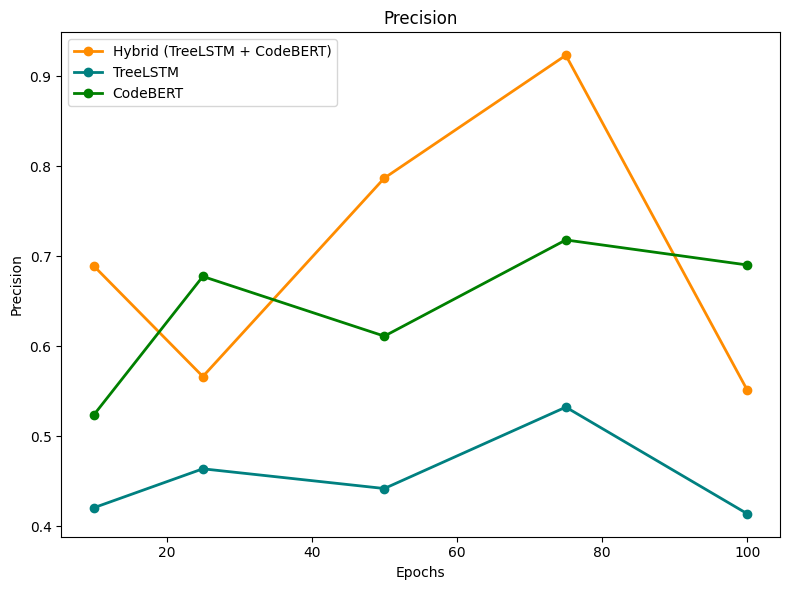

In [19]:
# Plotting the lines
plt.figure(figsize=(8, 6))

plt.plot(epoch, precision_h, marker='o', label='Hybrid (TreeLSTM + CodeBERT)', color='darkorange', linewidth=2)
plt.plot(epoch, precision_t, marker='o', label='TreeLSTM', color='teal', linewidth=2)
plt.plot(epoch, precision_b, marker='o', label='CodeBERT', color='green', linewidth=2)

# Adding title and labels
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')

# Rotate x-axis labels for better visibility
plt.xticks(ha='center')

# Adding legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

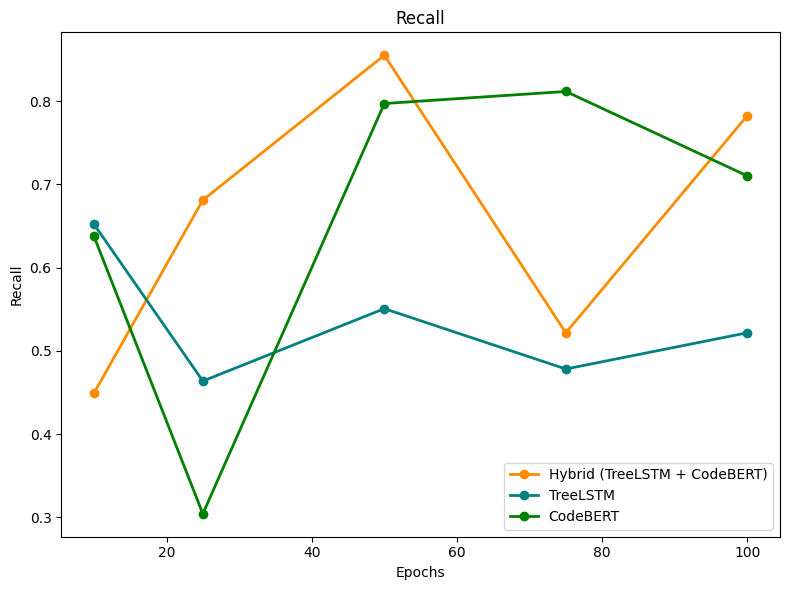

In [20]:
# Plotting the lines
plt.figure(figsize=(8, 6))

plt.plot(epoch, recall_h, marker='o', label='Hybrid (TreeLSTM + CodeBERT)', color='darkorange', linewidth=2)
plt.plot(epoch, recall_t, marker='o', label='TreeLSTM', color='teal', linewidth=2)
plt.plot(epoch, recall_b, marker='o', label='CodeBERT', color='green', linewidth=2)

# Adding title and labels
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')

# Rotate x-axis labels for better visibility
plt.xticks(ha='center')

# Adding legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

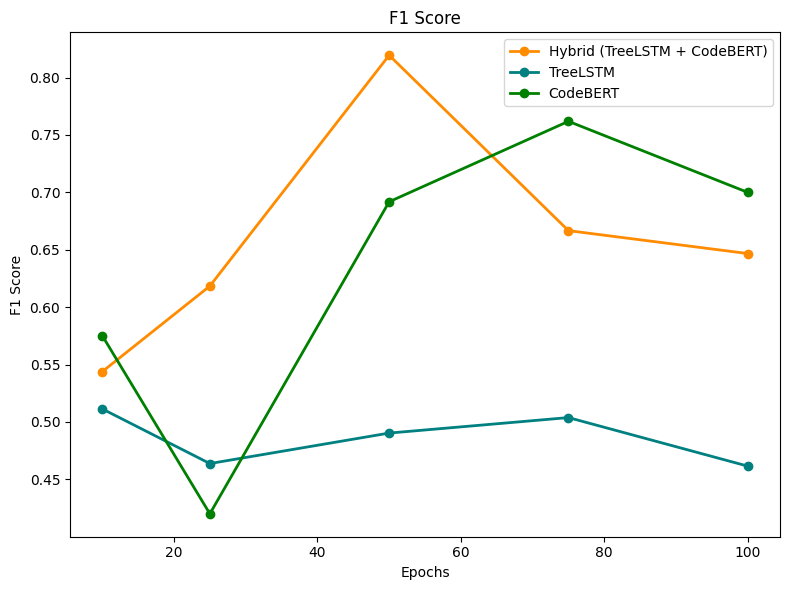

In [21]:
# Plotting the lines
plt.figure(figsize=(8, 6))

plt.plot(epoch, f1_h, marker='o', label='Hybrid (TreeLSTM + CodeBERT)', color='darkorange', linewidth=2)
plt.plot(epoch, f1_t, marker='o', label='TreeLSTM', color='teal', linewidth=2)
plt.plot(epoch, f1_b, marker='o', label='CodeBERT', color='green', linewidth=2)

# Adding title and labels
plt.title('F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')

# Rotate x-axis labels for better visibility
plt.xticks(ha='center')

# Adding legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

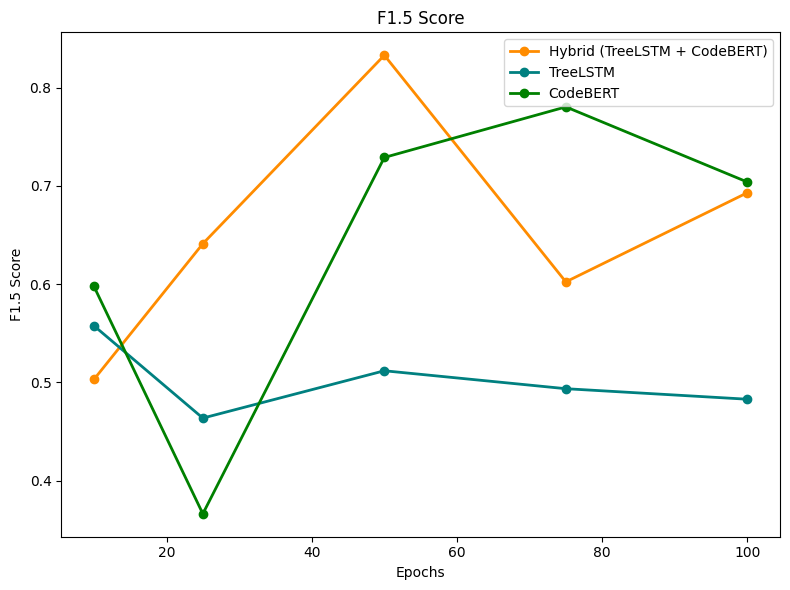

In [22]:
# Plotting the lines
plt.figure(figsize=(8, 6))

plt.plot(epoch, f15_h, marker='o', label='Hybrid (TreeLSTM + CodeBERT)', color='darkorange', linewidth=2)
plt.plot(epoch, f15_t, marker='o', label='TreeLSTM', color='teal', linewidth=2)
plt.plot(epoch, f15_b, marker='o', label='CodeBERT', color='green', linewidth=2)

# Adding title and labels
plt.title('F1.5 Score')
plt.xlabel('Epochs')
plt.ylabel('F1.5 Score')

# Rotate x-axis labels for better visibility
plt.xticks(ha='center')

# Adding legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()